In [ ]:
import os
import zipfile
import subprocess
import shutil

target_dir = r"../data/raw"
os.makedirs(target_dir, exist_ok=True)

kaggle_json_source = r"../kaggle.json" 
kaggle_dir = os.path.expanduser("~\\.kaggle") 
os.makedirs(kaggle_dir, exist_ok=True)

if not os.path.exists(kaggle_json_source):
    raise FileNotFoundError(f"Arquivo kaggle.json não encontrado em: {kaggle_json_source}")

shutil.copy(kaggle_json_source, os.path.join(kaggle_dir, "kaggle.json"))

try:
    import kaggle
except ImportError:
    subprocess.check_call(["pip", "install", "kaggle"])

print("Baixando o dataset do Kaggle...")
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", "paultimothymooney/blood-cells",
    "-p", target_dir,
    "--force"
])

dataset_zip = os.path.join(target_dir, "blood-cells.zip")
if os.path.exists(dataset_zip):
    print("Extraindo arquivos...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Dataset extraído em: {target_dir}")
else:
    print("Arquivo ZIP não encontrado.")


⏬ Baixando o dataset do Kaggle...
📂 Extraindo arquivos...
✅ Dataset extraído em: ../data/raw


In [ ]:
import os
import random
import cv2
import numpy as np
from tqdm import tqdm

IMAGE_SIZE = (256, 256)
AUGMENTATION_TIMES = 3

def load_image(path):
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Imagem não encontrada: {path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def resize(image):
    image_resized = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    return image_resized 

def normalize(image):
    return image / 255.0

def random_flip(image):
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    return image 

def random_rotation(image):
    angle = random.choice([0, 90, 180, 270])
    if angle == 0:
        return image
    k = angle // 90
    image_rotated = np.ascontiguousarray(np.rot90(image, k)) 
    return image_rotated 

def random_brightness_contrast(image):
    """Aplica apenas na imagem."""
    brightness = random.uniform(-0.2, 0.2)
    contrast = random.uniform(0.8, 1.2)

    img = image * contrast + brightness
    img = np.clip(img, 0, 1)
    return img

def random_zoom_crop(image):
    """Faz zoom e crop na imagem."""
    h, w = image.shape[:2]
    
    scale = random.uniform(0.95, 1.05) 
    nh, nw = int(h * scale), int(w * scale)

    image_resized = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_AREA)

    if scale < 1.0:
        pad_h = (h - nh) // 2
        pad_w = (w - nw) // 2
        image_padded = cv2.copyMakeBorder(
            image_resized, pad_h, h - nh - pad_h, pad_w, w - nw - pad_w, cv2.BORDER_REFLECT
        )
        return image_padded 
    else: 
        start_h = (nh - h) // 2
        start_w = (nw - w) // 2
        image_cropped = image_resized[start_h:start_h + h, start_w:start_w + w]
        
        if image_cropped.shape[0] != h or image_cropped.shape[1] != w:
            image_cropped = cv2.resize(image_cropped, (w, h), interpolation=cv2.INTER_AREA)

        return image_cropped 

def augment(image):
    """Aplica aumentações apenas na imagem."""
    img_aug = random_flip(image)
    img_aug = random_rotation(img_aug)
    img_aug = random_zoom_crop(img_aug)
    img_aug = random_brightness_contrast(img_aug)
    
    if img_aug.shape[0] != IMAGE_SIZE[1] or img_aug.shape[1] != IMAGE_SIZE[0]:
        img_aug = cv2.resize(img_aug, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

    return img_aug 


def process_and_save(
    image_dir, output_image_dir,
    augment_times=AUGMENTATION_TIMES
):
    os.makedirs(output_image_dir, exist_ok=True)

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))] 

    for img_file in tqdm(image_files, desc=f"Processando {image_dir}"):
        image_path = os.path.join(image_dir, img_file)

        base_name = os.path.splitext(img_file)[0]

        try:
            image = load_image(image_path)
        except FileNotFoundError as e:
            print(e)
            continue
        except Exception as e:
            print(f"Erro inesperado ao carregar {image_path}: {e}")
            continue


        image = resize(image) 
        image_norm = normalize(image)

        image_save = (image_norm * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_image_dir, img_file), cv2.cvtColor(image_save, cv2.COLOR_RGB2BGR))

        for i in range(augment_times):
            aug_img = augment(image_norm)
            
            aug_img_save = (aug_img * 255).astype(np.uint8)

            img_name = f"{base_name}_aug{i}.png"

            cv2.imwrite(os.path.join(output_image_dir, img_name), cv2.cvtColor(aug_img_save, cv2.COLOR_RGB2BGR))
            
            try:
                test_img = cv2.imread(os.path.join(output_image_dir, img_name))
                if test_img is None:
                    print(f"AVISO: Imagem aumentada {img_name} não pôde ser lida após ser salva!")
                elif test_img.shape != (IMAGE_SIZE[1], IMAGE_SIZE[0], 3): 
                    print(f"AVISO: Imagem aumentada {img_name} tem shape inesperado: {test_img.shape}")
            except Exception as e:
                print(f"AVISO: Erro ao verificar imagem salva {img_name}: {e}")

base_path = "../data/"
classes = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

for cls in classes:
    image_dir = os.path.join(base_path, "raw/dataset2-master/dataset2-master/images/TRAIN", cls)
    output_image_dir = os.path.join(base_path, "preprocessed/images/TRAIN", cls)

    print(f"\nProcessando classe: {cls}")
    print(f"Imagens em: {image_dir}")
    print(f"Saída imagens em: {output_image_dir}")

    process_and_save(image_dir, output_image_dir)


🚀 Processando classe: EOSINOPHIL
📂 Imagens em: ../data/raw/dataset2-master/dataset2-master/images/TRAIN\EOSINOPHIL
💾 Saída imagens em: ../data/processed/images/TRAIN\EOSINOPHIL


Processando ../data/raw/dataset2-master/dataset2-master/images/TRAIN\EOSINOPHIL: 100%|██████████| 2497/2497 [04:01<00:00, 10.34it/s]



🚀 Processando classe: LYMPHOCYTE
📂 Imagens em: ../data/raw/dataset2-master/dataset2-master/images/TRAIN\LYMPHOCYTE
💾 Saída imagens em: ../data/processed/images/TRAIN\LYMPHOCYTE


Processando ../data/raw/dataset2-master/dataset2-master/images/TRAIN\LYMPHOCYTE: 100%|██████████| 2483/2483 [04:33<00:00,  9.07it/s]



🚀 Processando classe: MONOCYTE
📂 Imagens em: ../data/raw/dataset2-master/dataset2-master/images/TRAIN\MONOCYTE
💾 Saída imagens em: ../data/processed/images/TRAIN\MONOCYTE


Processando ../data/raw/dataset2-master/dataset2-master/images/TRAIN\MONOCYTE: 100%|██████████| 2478/2478 [04:17<00:00,  9.63it/s]



🚀 Processando classe: NEUTROPHIL
📂 Imagens em: ../data/raw/dataset2-master/dataset2-master/images/TRAIN\NEUTROPHIL
💾 Saída imagens em: ../data/processed/images/TRAIN\NEUTROPHIL


Processando ../data/raw/dataset2-master/dataset2-master/images/TRAIN\NEUTROPHIL: 100%|██████████| 2499/2499 [04:11<00:00,  9.94it/s]


In [ ]:
import os
from cellpose import models
import cv2
import numpy as np

base_path = '../data/preprocessed/images/TRAIN'
output_base = '../data/preprocessed/masks/TRAIN'

os.makedirs(output_base, exist_ok=True)

model = models.CellposeModel(gpu=True, pretrained_model='cyto2')

def process_image(image_path, save_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f'Não foi possível ler {image_path}')
            return
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        masks, flows, styles = model.eval(img_rgb, diameter=None)
        
        cv2.imwrite(save_path, masks.astype(np.uint16))
    except Exception as e:
        print(f'Erro ao processar {image_path}: {e}')

for cell_type in os.listdir(base_path):
    cell_folder = os.path.join(base_path, cell_type)
    if not os.path.isdir(cell_folder):
        continue

    output_folder = os.path.join(output_base, cell_type)
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(cell_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(cell_folder, filename)
            mask_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '_mask.png')
            process_image(img_path, mask_path)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	win32 
python version: 	3.12.10 
torch version:  	2.7.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




pretrained model C:\Users\felip\.cellpose\models\cpsam not found, using default model


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_4480.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_4480_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_4480_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_5702.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_6863.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_6863_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_6863_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_6863_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_7721_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_9188_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_0_9188_aug2.png
Nenhuma célula detectada em ../data/processed/images/TR

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_15_447_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_15_447_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_15_4626.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_15_4626_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_15_4626_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_15_8215_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_15_8988.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_16_4935.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_16_4935_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_16_4935_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_16_4935_aug2.png
Nenhuma célula detectada em ../data/processed/

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_3449_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_3449_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_3911.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_4009.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_4009_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_4009_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_4009_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_5233.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_5233_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_5233_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_17_5233_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_18_1259.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_18_1259_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_18_2243.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_18_2243_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_18_2243_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_19_402.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_19_402_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_19_402_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_19_4413_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_19_4413_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_1_1433.jpeg
Nenhuma célula detectada em ../data/processed/images

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_1_9924_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_20_1146_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_21_1365.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_21_1365_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_21_1365_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_21_1365_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_22_1714.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_22_1714_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_22_1714_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_22_1714_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_22_6006.jpeg
Nenhuma célula detectada em ../data/processed

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_25_5883.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_25_5883_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_3342.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_3342_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_3342_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_3342_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_6265.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_6265_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_6265_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_6265_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_26_854_aug1.png
Nenhuma célula detectada em ../data/processed

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_2454_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_2454_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_3943_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_3943_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_3943_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_4587.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_4587_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_4587_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_4587_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_520.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_520_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_520_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_520_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_8388.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_27_8388_aug0.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_187_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_187_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_2566_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_4286_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_4286_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_5249.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_5249_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_5249_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_5249_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_5926_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_5926_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_7052.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_30_9922_aug0.png
Nenhuma célula detectada em ../data/proc

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_31_3517_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_31_7887.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_31_9420_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_31_980.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_31_980_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_31_980_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_31_980_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_32_249.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_32_249_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_32_249_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_32_249_aug2.png
Nenhuma célula detectada em ../data/processed/images

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_5032.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_5032_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_5032_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_5032_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_6617.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_6617_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_6617_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_6617_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_7031.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_7031_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_7031_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_8137.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_8137_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_8137_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_37_8137_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_38_2597_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_38_2597_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_38_3883.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_38_3883_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_38_3883_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_38_3883_aug2.png
Nenhuma célula detectada em ../data/proc

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_2120_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_2971.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_2971_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_2971_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_3318_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_3318_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_3318_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_4832.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_4832_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_4832_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_4832_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_7902.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_7902_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_7902_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_8099.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_8099_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_41_8099_aug1.png
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_2470.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_2470_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_2470_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_3987_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_3987_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_3987_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_6759_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_7315.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_7315_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_7315_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_43_7315_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_1103_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_1455.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_1455_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_1455_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_1455_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_5556_aug0.png
Nenhuma célula detectada em ../data/proc

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_790_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_44_8468.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_45_5949_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_45_6519_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_45_7992.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_46_4721.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_46_4721_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_46_4776.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_46_4776_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_46_4776_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_46_4776_aug2.png
Nenhuma célula detectada em ../data/processed/ima

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_49_6633_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_49_6633_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_49_9703.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_49_9703_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_2748.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_2748_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_2748_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_2748_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_4937.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_4937_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_4937_aug1.png
Nenhuma célula detectada em ../data/processed/image

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_6300_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_6300_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_6300_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_7440.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_7440_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_4_7440_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_50_639_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_51_1195_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_51_6110_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_52_4154_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_52_4154_aug1.png
Nenhuma célula detectada em ../data/process

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_53_7603_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_1064.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_1064_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_1064_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_1064_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_582.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_582_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_582_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_54_582_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_2200.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_2200_aug0.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_4190_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_5469_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_5469_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_6400_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_6400_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_55_7307_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_56_1651_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_56_4160.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_56_4160_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_56_4160_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_56_4160_aug2.png
Nenhuma célula detectada em ../data/

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_1991_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_368.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_368_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_368_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_4093.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_4093_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_4093_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_4093_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_988_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_990.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_61_990_aug0.png
Nenhuma célula detectada em ../data/processed/imag

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_2012.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_2012_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_2012_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_4026.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_4026_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_4026_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_4639.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_4639_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_4639_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_5723.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_65_5723_aug0.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_69_6017_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_69_6017_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_69_6017_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_2466.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_2466_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_2466_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_2466_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_2515.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_2515_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_2515_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_6_8688_aug0.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_70_6660.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_70_6660_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_70_6660_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_70_6660_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_71_7811_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_71_7811_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_71_7811_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_71_9156.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_71_9156_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_71_9156_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_71_9156_aug2.png
Nenhuma célula detectada em ../data/proc

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_73_7720_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_73_8569_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_73_8569_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_73_8569_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_74_437_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_74_6391.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_74_6391_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_74_6391_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_74_6391_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_7_3468.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_7_3468_aug2.png
Nenhuma célula detectada em ../data/process

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_8_9869_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_7180.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_7180_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_7180_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_7180_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_9685.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_9685_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_9685_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_9685_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\EOSINOPHIL\_9_9893_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_1437.jpeg
Nenhuma célula detectada em ../data/processed/images/TR

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2322_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2664.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2664_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2664_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2664_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2790.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2790_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_2790_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_3283.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_3283_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_4378.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5066_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5066_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5066_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5313.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5313_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5313_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5313_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5396_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_547.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_547_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5620.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5620_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5620_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5919.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_5919_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_6087.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_6087_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_6087_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_6087_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_6419.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_6419_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_918.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_918_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_0_918_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1221.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1221_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1221_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1221_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1467.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1467_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1467_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_1467_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_2417.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_2417_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_2417_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3699.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3699_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3699_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3777_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3794.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3794_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3966.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_3966_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_4005.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_4005_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_4005_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_4224.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_4224_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_4224_aug1.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_5936.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_5936_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_5936_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6038.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6038_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6038_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6038_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6292.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6292_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6292_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6885.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6885_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6885_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_6885_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_8251.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_8392_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_8915.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_8915_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_8915_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_8915_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_9051_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_9982.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_9982_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_9982_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_10_9982_aug2.png
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_217_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_2788.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_2788_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_3997.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_3997_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_4579.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_4579_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_4579_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_4579_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_5165_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_5165_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_6718_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_11_7112.jpeg
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_2782_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_2787.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_2787_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_2787_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_2835.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_2835_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_2835_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_415.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_415_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_415_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_415_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_12_4412.jpeg
Nenhuma célula detectada em ../data/processed/images

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_4523_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_4523_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_5792.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_5792_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_5792_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_5792_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_6859.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_6859_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_6859_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_6859_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_13_6886.jpeg
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_367_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_367_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_367_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_3732_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_42.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_42_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_42_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_42_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_4338.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_4338_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_4445.jpeg
Nenhuma célula detectada em ../data/processed/images/TR

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5427.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5427_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5427_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5427_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5605_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_561_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5886.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5886_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5886_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5886_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_5991.jpeg
Nenhuma célula detectada em ../data/processed

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_9290_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_938.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_938_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_9412.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_9412_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_9412_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_14_9412_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_1445.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_1445_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_1445_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_1445_aug2.png
Nenhuma célula detectada em ../data/processed/

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_2793.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_2793_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_3079.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_3079_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_3079_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_3079_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_4064.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_4187.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_4187_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_4187_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_4187_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_4290_aug0.png
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_6296_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_6296_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_696.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7230.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7230_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7230_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7230_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7305.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7305_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7305_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7305_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7744.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7744_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_7744_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8098.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8098_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8098_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8098_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8369.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8369_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8369_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_15_8452.jpeg
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_1029.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_1029_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_1429_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_1429_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_279_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_279_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_3037.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_3037_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_3037_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_3037_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_3429.jpeg
Nenhuma célula detectada em ../data/processed/

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5240_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5622.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5622_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5622_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5624.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5624_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5624_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5649.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5649_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5649_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5649_aug2.png
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5833.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5833_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5833_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_5833_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_6729.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7195.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7195_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7195_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7195_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7964.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7964_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7964_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_7964_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_8297.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_17_8484.jpeg
Nenhuma célula detectada em ../data/processed/images

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_4728_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_4728_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_4728_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_4839.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_4839_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_5189.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_5189_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_5189_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_5551.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_5700.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_18_5700_aug1.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_2606.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_2606_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_2606_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_2905.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_2905_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_2905_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_3027_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_3043_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_3311.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_3311_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_3311_aug1.png
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_573_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_573_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_573_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_5819_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_6196.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_6196_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_6196_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_6196_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_7216.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_7216_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_7224.jpeg
Nenhuma célula detectada em ../data/processed/i

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_7568_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_8886.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_8886_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9082.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9082_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9121.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9121_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9121_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9121_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9399.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9399_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9399_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9667.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_19_9667_aug0.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_818.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_818_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_8326.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_8326_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_841.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_841_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_841_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_841_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_8458_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_8728.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_1_8728_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHO

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_4561.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_4764.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_4764_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_4764_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_5078_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_5714_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_5714_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_6092.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_6296.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_6762.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_6762_aug0.png
Nenhuma célula detectada em ../data/processed/images

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_6945_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_6945_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_6945_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_7009_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_7009_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_7009_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_7867.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_7937_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_7937_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_8055.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_8055_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_8055_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_8640.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_8640_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_20_8640_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_1357.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_1357_aug0.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_2194_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_2194_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_2194_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_3317.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_3317_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_3317_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_3317_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_4091.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_4091_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_4091_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_4091_aug2.png
Nenhuma célula detectada em ../data/proc

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_5916_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_5961.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_5961_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_5961_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_6008.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_6008_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_6008_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_6008_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_6027.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_6027_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_6027_aug1.png
Nenhuma célula detectada em ../data/processe

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_9578_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_9918_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_9918_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_21_9918_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_1819.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_1819_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_1819_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_1819_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_2475.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_2475_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_2475_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_2781.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_2781_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_314.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_3632.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_3632_aug0.png
Nenhuma célula detectada em ../data/processed/ima

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_8002_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_809.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_809_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_809_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_8200.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_8438.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_8438_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_8438_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_854_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_854_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_22_8790.jpeg
Nenhuma célula detectada em ../data/processed/images/

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_23_8837_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_23_9646.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_23_9646_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_23_9646_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_23_9705.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_23_9705_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_23_9705_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_24_154_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_24_1842.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_24_1842_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_24_1842_aug1.png
Nenhuma célula detectada em ../data/processed

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_8017.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_8017_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_8017_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_8017_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_8363.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_8363_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9060.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9060_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9060_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9181.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9181_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9181_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9181_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9245.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9245_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9245_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9245_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9870.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9870_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9870_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_25_9870_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1036.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1036_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1036_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1036_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1152.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1152_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_116_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_193.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_193_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_193_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_193_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1967.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1967_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_1967_aug1.png
Nenhuma célula detectada em ../data/processed/ima

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_8964_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_8964_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_9218_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_9218_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_9333.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_9333_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_9333_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_26_9333_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_1283.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_1283_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_1283_aug2.png
Nenhuma célula detectada em ../data/process

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2233_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2233_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2521.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2521_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2521_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2521_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2674_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2674_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2736.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2736_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2736_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_2790_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3001.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3001_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3001_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3001_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3135.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3135_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3135_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3135_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3406.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_3406_aug0.png
Nenhuma célula detectada em ../data/processed/images/TR

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_4937_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_4937_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_4999.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_4999_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_4999_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_4999_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_51.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_51_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_51_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_6342.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_6342_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LY

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8172.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8172_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8172_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8693_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8743.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8743_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8743_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8815.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8815_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8815_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_2_8815_aug2.png
Nenhuma célula detectada em ../data/processed/images/TR

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_3_8504_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_3_8504_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_3_9222.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_3_9222_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_3_9316.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_3_9316_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_3_9316_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_1019.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_1019_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_1019_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_1474.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_2290_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_2290_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_2290_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_2605.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_2605_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_2605_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_2605_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_4_261_aug0.png
Nenhuma célula detectada em ../data/processed/images

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_373_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_373_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_373_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_3856.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_3856_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_3856_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_3856_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_4641_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_4762_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_4762_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5330.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5472.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5472_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5472_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5472_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5884.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5884_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5884_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_5884_aug2.png
Nenhuma célula detectada em ../data/processed/images/TR

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_7264_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_7985.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_7985_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_7985_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_7985_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_9697_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_9697_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_5_9697_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_6_137.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_6_137_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_6_137_aug2.png
Nenhuma célula detectada em ../data/processed/images/T

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_6_9229_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_6_9687_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_1175.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2086_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2270.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2270_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2449.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2449_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2449_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2449_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_7_2487.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3073_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3073_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3811.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3811_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3811_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3902.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3902_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3902_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_3902_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_4259.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_4259_aug0.png
Nenhuma célula detectada em ../data/processed/images/TR

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_4259_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_4361_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_4361_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_4385.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_4385_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_520.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_520_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_520_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_5468_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_743.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_743_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\L

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9169.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9216.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9216_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9216_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9216_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9836.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9836_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9836_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_8_9836_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_9_1601.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\LYMPHOCYTE\_9_1601_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_3912_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_3998.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_3998_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_4407_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_4715.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_4715_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_4715_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_4872_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_5144_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_5486_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_5486_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_5888_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_58

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_6035_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_6229_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_6229_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_6357.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_6357_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_780.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_780_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_780_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_780_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_8643_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_9393_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_0_9591_a

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_2614_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_2614_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_3016.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_3016_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_3016_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_3443_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_3443_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_3888_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_3888_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_4312.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_4312_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MON

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_4375.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_4375_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_51_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_5593_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_5593_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_5593_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_5720.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_6450.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_6450_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_6450_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_10_6450_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_6753_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_6753_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_6969.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_6969_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_7110.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_7110_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_7110_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_7110_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_7500_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_7681_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_7681_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_786_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_786_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_8255.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_8255_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_8780_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_9550.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_9550_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_9550_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_12_9550_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_1123.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_1123_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_1123_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_1291.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_1291_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_1291_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYT

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_7805_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_7805_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_8936_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_8936_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_9138.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_9138_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_9177.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_9177_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_13_9177_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1040.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1040_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1040_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1040_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1205_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1205_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1836_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_1840_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_2764_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_2984_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_3061.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_3061_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_3061_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_3169_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_3774.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_3774_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_5969_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_5969_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6742.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6742_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6742_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6908_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6938_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_694_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6971.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6971_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_6971_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_7022.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_7424.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_7424_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_7534.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_7792_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_7884_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_847_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_847_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_847_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_9115_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_14_9515.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_1043_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_1063_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_1799.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_6659.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_6659_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_6659_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_7105.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_9789_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_9789_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_9789_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_9871.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_9871_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_9871_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_15_9871_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYT

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_1289_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_1289_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_223_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_2543.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_2543_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_371.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4049.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4049_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4129_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4129_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4284.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4284_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4942.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4942_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_4942_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_5194_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_5788.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_5955_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6352_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6352_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6490.j

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6673_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6680.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6710_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6710_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6858.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6858_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6858_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_6858_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_702_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_7450_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_8069.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_8069_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_9006.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_9006_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_9006_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_9087_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_1_908

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_6366.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_6555_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_6555_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_7471.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_7471_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_7471_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_8089.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_8089_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_8089_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_8089_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_8230.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_2_8230_aug0.

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_3735_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_3738.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_3785.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_3785_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_3785_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_3785_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_4012_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_4249_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_427.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_427_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_427_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_4764.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_5185.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_5185_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_556_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_556_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_5918.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_5918_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_5918_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_5918_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_5919_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_6405_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_6405_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_6593.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_6593_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_6593_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_6656_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_6656_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_7044.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_7044_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_7068.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_7251_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_77_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_8805.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_9146.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_9146_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_3_9992_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_1299_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_1354.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_1363_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_1593_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_1593_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_1595.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_1595_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3019.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3019_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3019_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3019_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3096.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3096_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3096_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3156.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3156_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_4_3646_aug1.

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_7868.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_7868_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_7868_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_7868_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_8768.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_8768_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_9510_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_9510_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_5_9510_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_1456.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_1456_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_1456_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_2252_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_2252_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_22

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_4567_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_4567_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_4567_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_4856_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_6366.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_6366_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_6366_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_6378_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_7514_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_7514_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_7516_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_7516_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_7871_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_7871_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_8110.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_8110_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_840_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_8650_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_9036_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_9309.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_9309_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_9309_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_9407_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_6_9605_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_1580_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_2405_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_2405_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_2520.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_2520_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_2520_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_272_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_3135.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_3135_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_3135_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_340

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_3808_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_3931.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_3931_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_3931_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_4846_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_4846_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_5674.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_5752_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_6113_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_6113_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_6113_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_7_72

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_1798_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_2576_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_2576_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_3373_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_4355_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_4451.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_4451_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_4566_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_4566_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_4670_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_5075.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_50

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_9765.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_9765_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_9765_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_9975.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_8_9975_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_1691_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_2952.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_3707.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_3707_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_3707_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_3707_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4040_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4040_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4044.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4044_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4650_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4650_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4756.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_4756_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5341_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5341_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5342_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5598.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5598_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5598_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5734.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5971.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_5971_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_7599_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_7599_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_7657.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_7657_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_7687_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_7687_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_8408_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\MONOCYTE\_9_8408_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_0_5763.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_0_5763_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_0_5763_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_0_5763_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_100_7356.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_100_8625_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_100_8625_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_101_4604.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_101_4604_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_101_4604_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_101_9225_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_101_9225_aug2.png
Nenhuma célula detectada em ../data

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_104_8533_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_105_3457.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_105_3457_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_105_3457_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_105_3457_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_105_6151_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_105_9303_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_106_2470_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_106_2470_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_107_2956_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_108_5388.jpeg
Nenhuma célula detectada em .

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_118_3351_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_119_5269_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_119_5269_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_11_4171.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_11_4171_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_11_4171_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_11_4171_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_121_1942_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_121_6402.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_121_6663_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_121_6663_aug1.png
Nenhuma célula detectada em ../da

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_127_8007_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_128_7262_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_129_8103_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_129_8103_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_12_7332_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_12_8847.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_12_8847_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_131_3441_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_132_2983_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_132_7559_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_133_8957.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_133_8957_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_133_8957_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_133_8957_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_134_5658_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_134_5658_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_135_2320.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_135_2320_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_135_2320_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_137_225.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_137_225_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_137_225_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_137_225_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_139_7884_aug0.png
Nenhuma célula detectada em ../da

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_26_1257_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_26_1257_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_26_5915.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_26_5915_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_26_5915_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_26_5915_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_2_1721.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_2_1721_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_2_1721_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_2_6323_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_2_6323_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_30_6107_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_30_6107_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_33_9795_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_34_7704.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_35_4874_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_36_4898_aug1.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_37_9677.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_37_9677_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_37_9677_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_3223.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_3223_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_3223_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_3223_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_9444.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_9444_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_9444_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_38_9444_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_39_380_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_39_6804.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_39_6804_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_39_6804_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_39_6804_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_39_7555_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_39_9868_aug1.png
Nenhuma célula detectada em ../data/proce

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_4_3186_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_4_3186_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_51_4256.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_51_4256_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_51_4256_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_52_6408_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_54_7169_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_3507.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_3507_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_3507_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_7385.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_7385_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_9983.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_9983_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_9983_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_56_9983_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_57_9565.jpeg


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_58_6669_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_58_6669_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_59_5588_aug0.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_59_5588_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_60_8237.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_60_8237_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_60_8639.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_60_8639_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_60_8639_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_60_8639_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_61_3290.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_61_3290_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_63_3734.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_63_5324_aug1.png
Nenhuma célula detectada em ../data/processed/im

no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_74_262_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_74_3514_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_74_3561_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_74_5767_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_75_7354.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_75_7354_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_75_7354_aug2.png


no seeds found in get_masks_torch - no masks found.


Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_75_9085.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_75_9085_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_76_2594_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_78_1031.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_78_1031_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_78_1031_aug1.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_78_1031_aug2.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_79_2188.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_79_2188_aug0.png
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_79_4634.jpeg
Nenhuma célula detectada em ../data/processed/images/TRAIN\NEUTROPHIL\_79_4634_aug0.png
Nenhuma célula detectada em ../data/processed/im

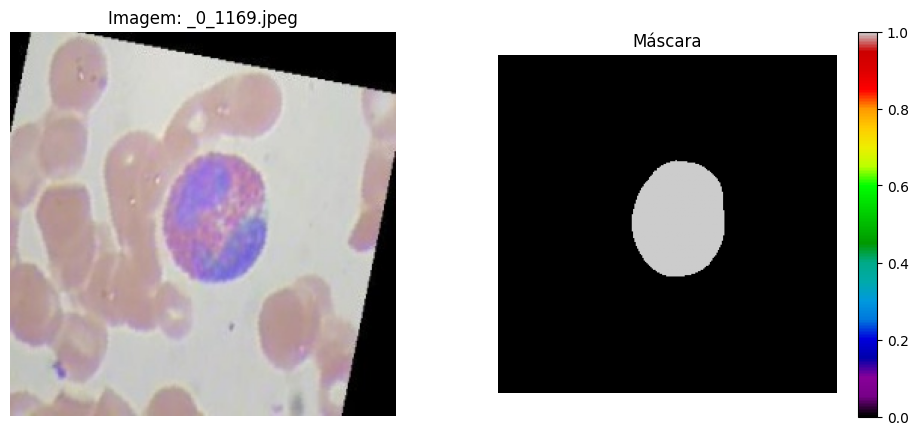

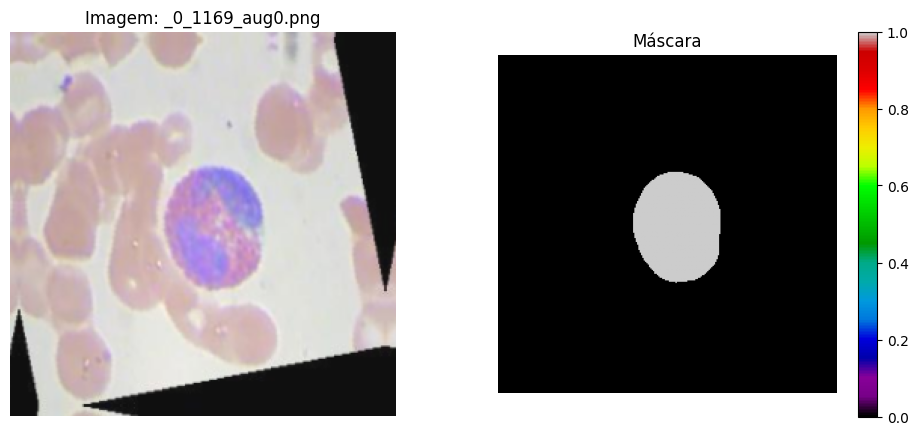

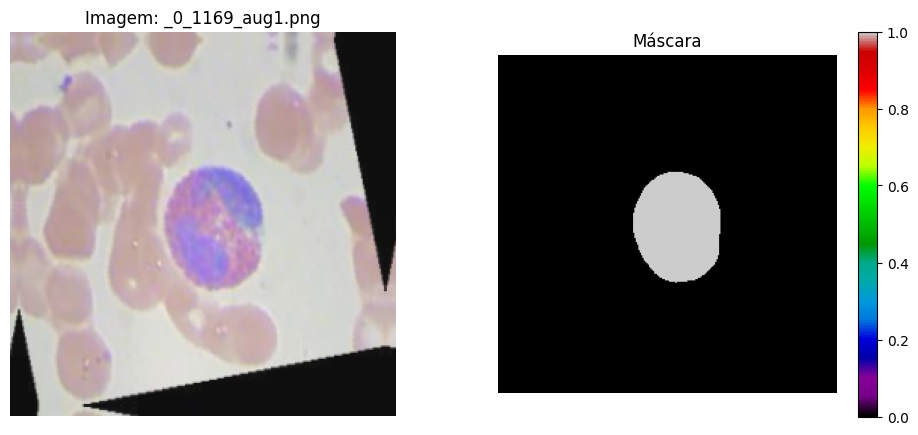

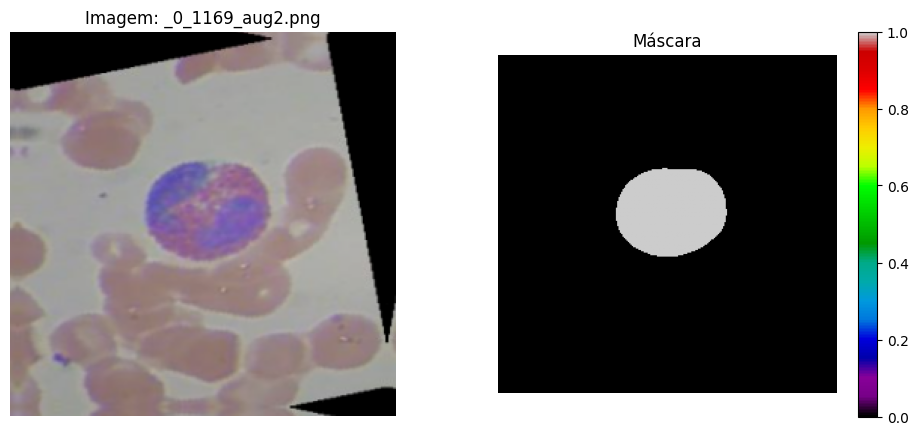

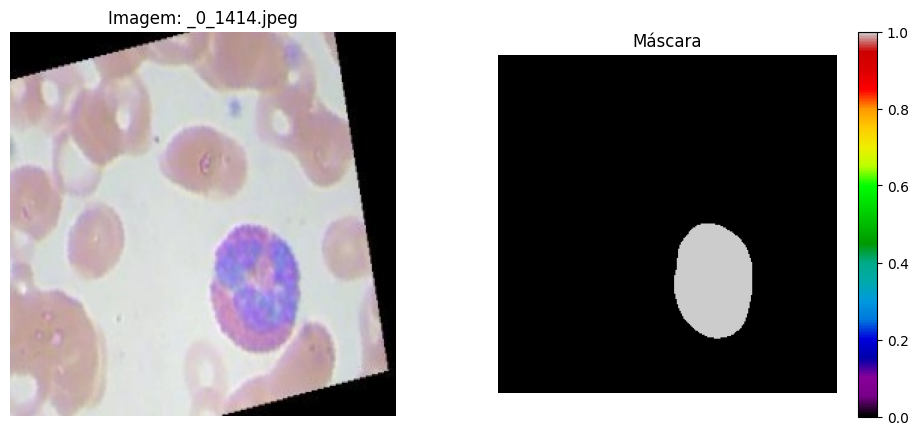

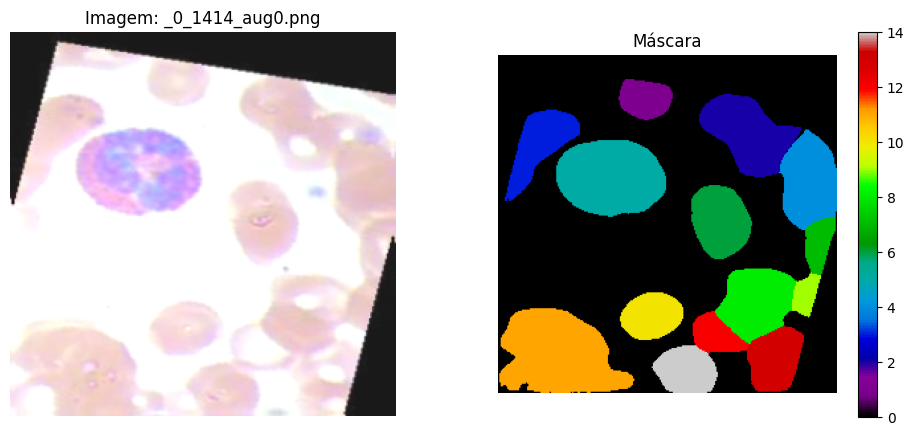

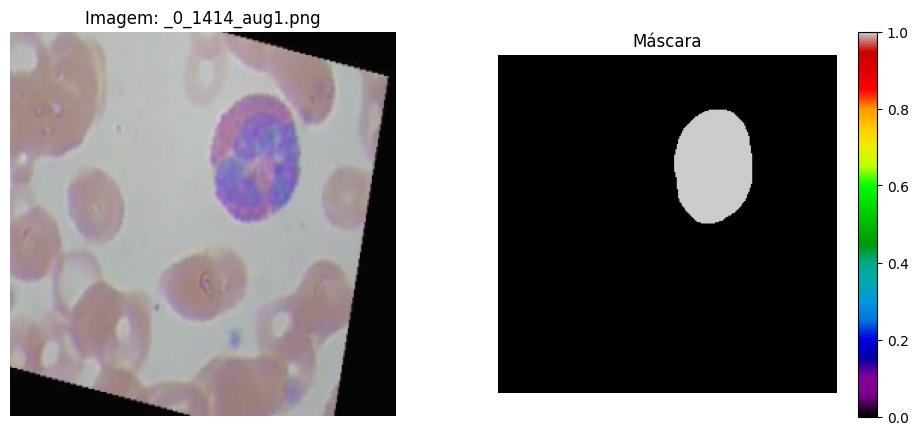

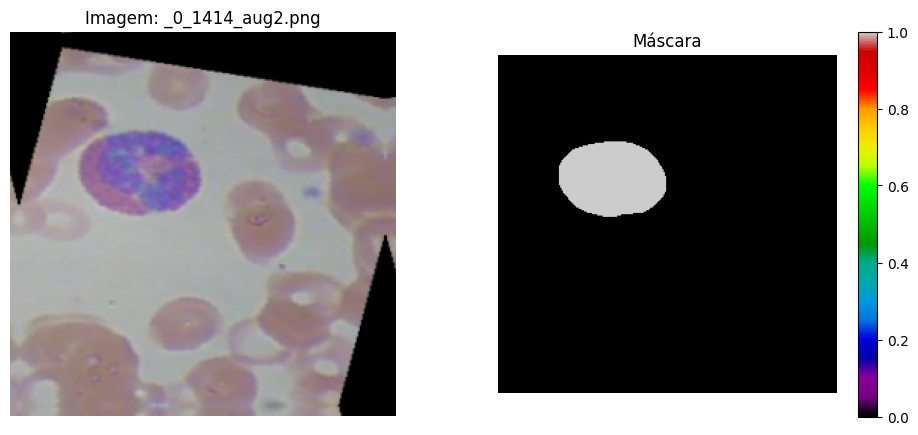

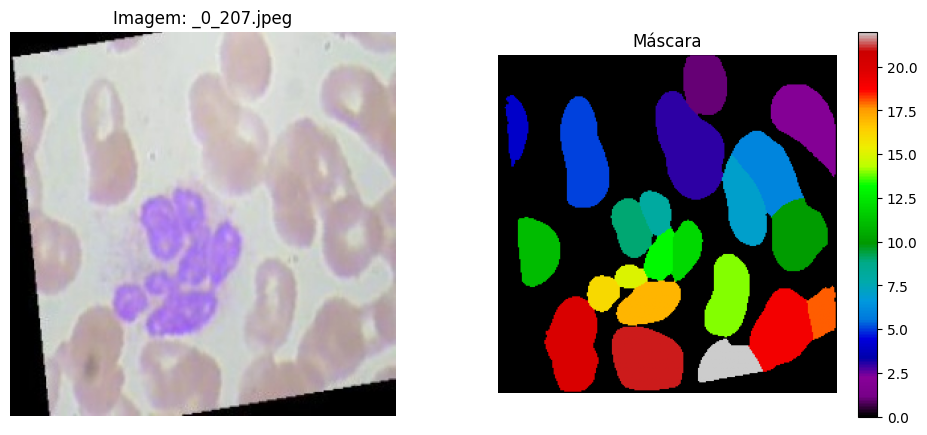

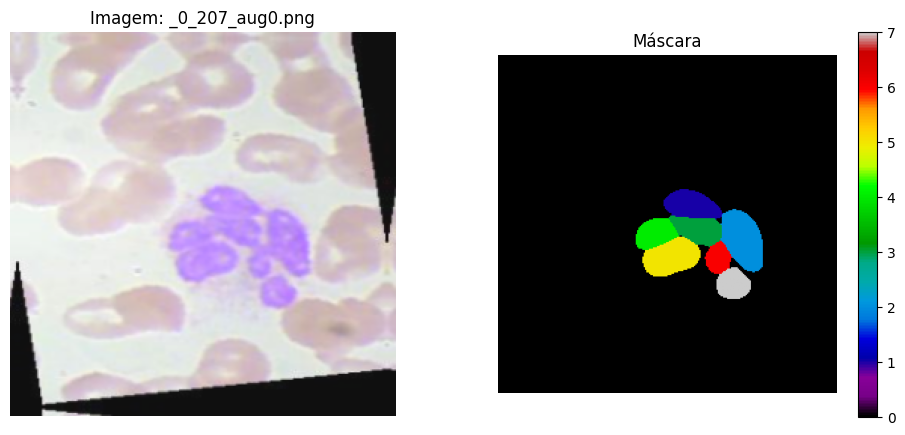

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

base_path = "../data/preprocessed/"
classe = "EOSINOPHIL"
img_dir = os.path.join(base_path, "images/TRAIN", classe)
mask_dir = os.path.join(base_path, "masks/TRAIN", classe)

colors = ['black', 'red', 'green', 'blue', 'yellow', 'magenta']

filenames = sorted([
    f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])[:10]

for filename in filenames:
    img_path = os.path.join(img_dir, filename)
    base_name = os.path.splitext(filename)[0]
    mask_name = base_name + "_mask.png"
    mask_path = os.path.join(mask_dir, mask_name)

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f'Imagem: {filename}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='nipy_spectral')
    plt.title('Máscara')
    plt.colorbar()
    plt.axis('off')

    plt.show()

In [ ]:
import os
import shutil
import random

SOURCE_IMAGES = '../data/preprocessed/images/TRAIN'
SOURCE_MASKS = '../data/preprocessed/masks/TRAIN'

TARGET_IMAGES = '../data/processed/images'
TARGET_MASKS = '../data/processed/masks'

CLASSES = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

SPLIT_RATIO = {
    'train': 0.7,
    'val': 0.15,
    'test': 0.15
}

def create_dirs(base_dir):
    for split in SPLIT_RATIO.keys():
        for cls in CLASSES:
            os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

create_dirs(TARGET_IMAGES)
create_dirs(TARGET_MASKS)

def split_dataset():
    for cls in CLASSES:
        img_src_folder = os.path.join(SOURCE_IMAGES, cls)
        mask_src_folder = os.path.join(SOURCE_MASKS, cls)

        img_files = os.listdir(img_src_folder)
        img_files = [f for f in img_files if os.path.isfile(os.path.join(img_src_folder, f))]

        valid_files = []
        for img_file in img_files:
            name, ext = os.path.splitext(img_file)
            mask_file = name + '_mask' + ext
            if os.path.exists(os.path.join(mask_src_folder, mask_file)):
                valid_files.append(img_file)

        random.shuffle(valid_files) 

        n_total = len(valid_files)
        n_train = int(n_total * SPLIT_RATIO['train'])
        n_val = int(n_total * SPLIT_RATIO['val'])

        train_files = valid_files[:n_train]
        val_files = valid_files[n_train:n_train + n_val]
        test_files = valid_files[n_train + n_val:]

        splits = {
            'train': train_files,
            'val': val_files,
            'test': test_files
        }

        for split, files in splits.items():
            for file in files:
                name, ext = os.path.splitext(file)
                mask_file = name + '_mask' + ext

                img_src = os.path.join(img_src_folder, file)
                img_dst = os.path.join(TARGET_IMAGES, split, cls, file)

                mask_src = os.path.join(mask_src_folder, mask_file)
                mask_dst = os.path.join(TARGET_MASKS, split, cls, mask_file)

                shutil.copyfile(img_src, img_dst)

                shutil.copyfile(mask_src, mask_dst)

        print(f'Classe {cls} - Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}')

split_dataset()

✅ Classe EOSINOPHIL - Train: 5243, Val: 1123, Test: 1125
✅ Classe LYMPHOCYTE - Train: 5214, Val: 1117, Test: 1118
✅ Classe MONOCYTE - Train: 5203, Val: 1115, Test: 1116
✅ Classe NEUTROPHIL - Train: 5247, Val: 1124, Test: 1126
